<a href="https://colab.research.google.com/github/AshikaAnand12/SpecialTopicsProject/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autoencoders

A sort of neural network known as an autoencoder breaks down an input (such as an image or dataset) into its essential properties before recreating the input in the opposite direction. Even though it may seem futile to put in input only to get the same thing back, this strategy is quite helpful for a variety of applications. The autoencoder reduces (encodes) the input into a few crucial features that it chooses on its own without any outside guidance. The input is automatically encoded, therefore the name "autoencoder."

When using autoencoders, it is assumed that fraud or anomalies will have a detectably high reconstruction error.

### Imports

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [9]:
#Import Necessary Packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams

import pickle

In [10]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


### Access Data


**First set of steps followed:**

Please comment out this section if second set of steps followed

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/"

In [13]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [14]:
dataFrame = pd.read_csv("./creditcard.csv")

**Second set of steps followed:**

In [15]:
# dataFrame = pd.read_csv("/content/sample_data/creditcard.csv")

### Load Data

The data includes 492 fraudulent transactions out of 284,807 total transactions using European credit cards over the course of two days. A Principle Component Analysis (PCA) has been used to reduce everything except the time and amount due to privacy concerns.

In [16]:
dataFrame.isnull().values.any()

False

In [17]:
dataFrame.shape

(284807, 31)

In [18]:
dataFrame.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Analysis

Let's see some graphic proof that the data in this fraud dataset is uneven.

([<matplotlib.axis.XTick at 0x7f15f17d8a90>,
 [Text(0, 0, 'Normal'), Text(0, 0, 'Fraud')])

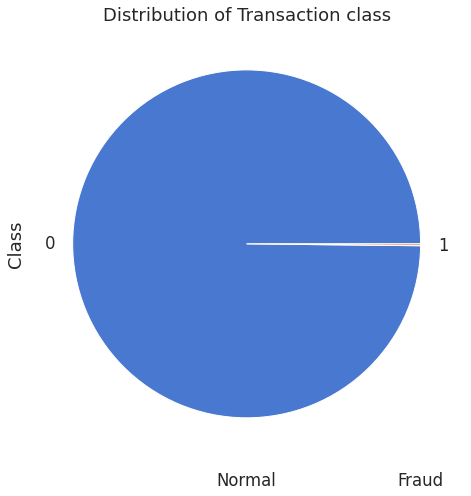

In [19]:
countClasses = pd.value_counts(dataFrame['Class'], sort = True)
countClasses.plot(kind = 'pie', rot=0)
plt.title("Distribution of Transaction class")
plt.xticks(range(2), LABELS)

### Overview of Transaction Amount Data Statistics

Two data frames, one for legitimate transactions and the other for fraud, will be created from the dataset.

In [20]:
fraudData = dataFrame[dataFrame.Class == 1]
normalData = dataFrame[dataFrame.Class == 0]

In [21]:
normalData.shape

(284315, 31)

In [22]:
fraudData.shape

(492, 31)

In [23]:
normalData.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [24]:
fraudData.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Even while the mean in the fraudulent transactions is a little higher, it is still within a standard deviation, making it difficult to distinguish between the classes with high precision using only statistical approaches.

### Visual Exploration of Transaction Amount vs. Hour

Again, this is insufficient to create a reliable classifier. For instance, it would be challenging to clearly delineate between legitimate business transactions and fraud.

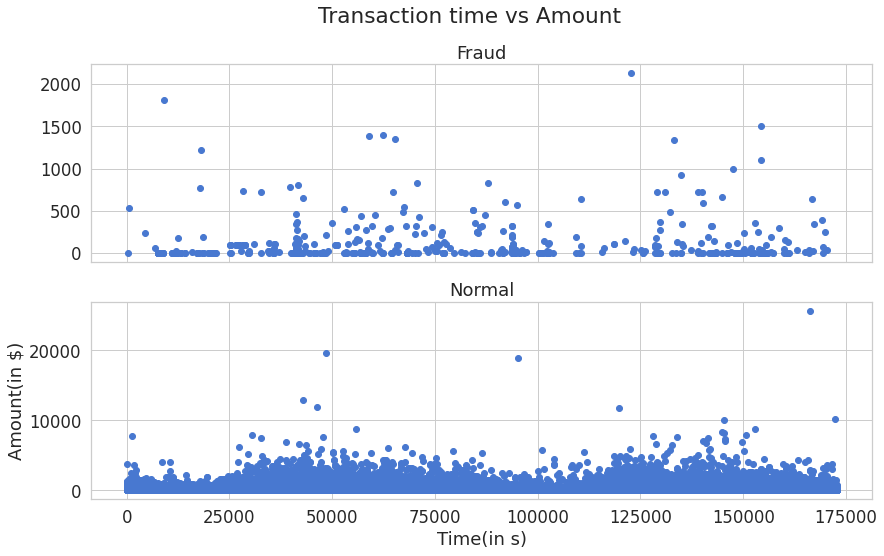

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Transaction time vs Amount')

ax1.scatter(fraudData.Time, fraudData.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalData.Time, normalData.Amount)
ax2.set_title('Normal')

plt.xlabel('Time(in s)')
plt.ylabel('Amount(in $)')
plt.show()


### Examination of the Transaction Amount Data Visually

The areas of interest in datasets for anomaly identification frequently become "washed away" by an abundance of data. Many low-value transactions that are often boring can be found in this dataset (buying cups of coffee, lunches, etc). Looking at transactions that are $200 or more will likely provide information that the rest of the data is likely to obscure.

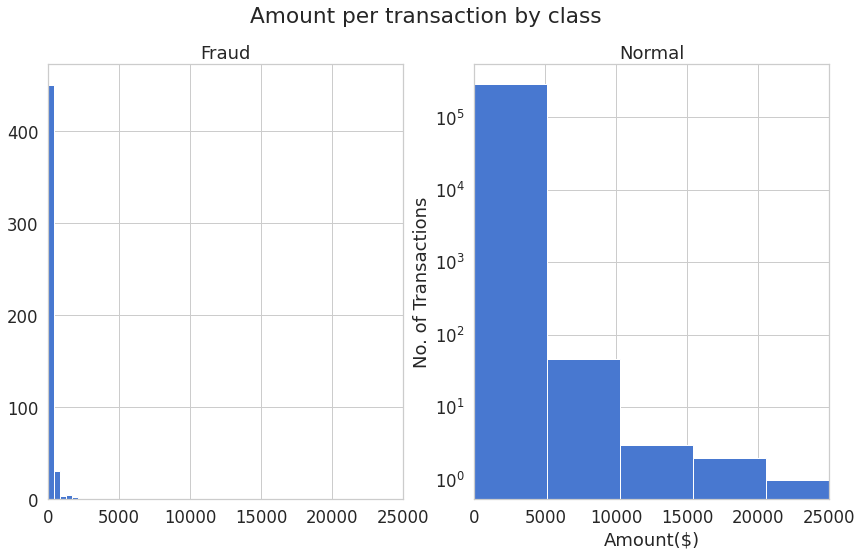

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True)
fig.suptitle('Amount per transaction by class')

bins = 5

ax2.hist(normalData.Amount, bins = bins)
ax2.set_title('Normal')

ax1.hist(fraudData.Amount, bins = bins)
ax1.set_title('Fraud')

plt.xlabel('Amount($)')
plt.ylabel('No. of Transactions')
plt.xlim((0, 25000))
plt.yscale('log')
plt.show();

### Setup of the Model: Basic Autoencoder

We are justified in investigating our autoencoder to see if it performs a little bit better now that more straightforward ways are not showing to be all that effective.

#### Scale and normalize data
Since time and quantity have extremely different magnitudes, the high magnitude value will probably "wash out" the small magnitude value. As a result, scaling the data to comparable magnitudes is frequent. As the majority of the data (aside from "time" and "amount") are the end result of a PCA analysis. The dataset was transformed into standard-normal form by the PCA performed on it. The columns for "time" and "amount" will get the same treatment.

In [27]:
data = dataFrame.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

#### Dividing the test and training sets

Now, using a random seed that we wrote at the beginning of the code, we divided the data into training and testing sets based on the percentage.

In [28]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [29]:
X_train.shape

(199008, 29)

In [30]:
inputDim = X_train.shape[1]
encodingDim = 14

In [31]:
input_layer = Input(shape=(inputDim, ))

encoder = Dense(encodingDim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encodingDim / 2), activation="relu")(encoder)

decoder = Dense(int(encodingDim / 2), activation='tanh')(encoder)
decoder = Dense(inputDim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

####Model Creation

**Structure and parameters of the autoencoder layer:**

Layers for symmetric encoding and decoding are "dense" in the autoencoder. The input is being compressed into a kind of streamlined encoding before being expanded once more. The feature space is the input and output dimension (for example, 30 columns), therefore the encoding layer should be thinner by the expected quantity of features it expects to represent. High-level characteristics should be represented by about two columns in this situation because I am encoding 30 columns into 14 dimensions (30/14 = 2.1). I anticipate that each of those high-level features will correspond to around seven latent or hidden features in the data.

Also tuned to experimentally sound settings were the epochs, batch size, learning rate, learning strategy, and activation functions.

In [32]:
#Training and Logging Models
#The complete setup for the run, including 
nb_epoch = 50
batch_size = 15

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="fraudDetection.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
13268/13268 [==============================] - 30s 2ms/step - loss: 0.8101 - accuracy: 0.5782 - val_loss: 0.7700 - val_accuracy: 0.6703
Epoch 2/50
13268/13268 [==============================] - 29s 2ms/step - loss: 0.7381 - accuracy: 0.6819 - val_loss: 0.7526 - val_accuracy: 0.6890
Epoch 3/50
13268/13268 [==============================] - 30s 2ms/step - loss: 0.7271 - accuracy: 0.6922 - val_loss: 0.7456 - val_accuracy: 0.6993
Epoch 4/50
13268/13268 [==============================] - 30s 2ms/step - loss: 0.7220 - accuracy: 0.6947 - val_loss: 0.7435 - val_accuracy: 0.6996
Epoch 5/50
13268/13268 [==============================] - 31s 2ms/step - loss: 0.7192 - accuracy: 0.6971 - val_loss: 0.7390 - val_accuracy: 0.7029
Epoch 6/50
13268/13268 [==============================] - 31s 2ms/step - loss: 0.7165 - accuracy: 0.6988 - val_loss: 0.7374 - val_accuracy: 0.7070
Epoch 7/50
13268/13268 [==============================] - 33s 2ms/step - loss: 0.7147 - accuracy: 0.7011 - val_loss: 0

In [33]:
autoencoder = load_model('fraudDetection.h5')

#### Model assessment

More training epochs are probably not going to assist because the loss of our present model appears to be convergent. Let's investigate this visually to make sure.

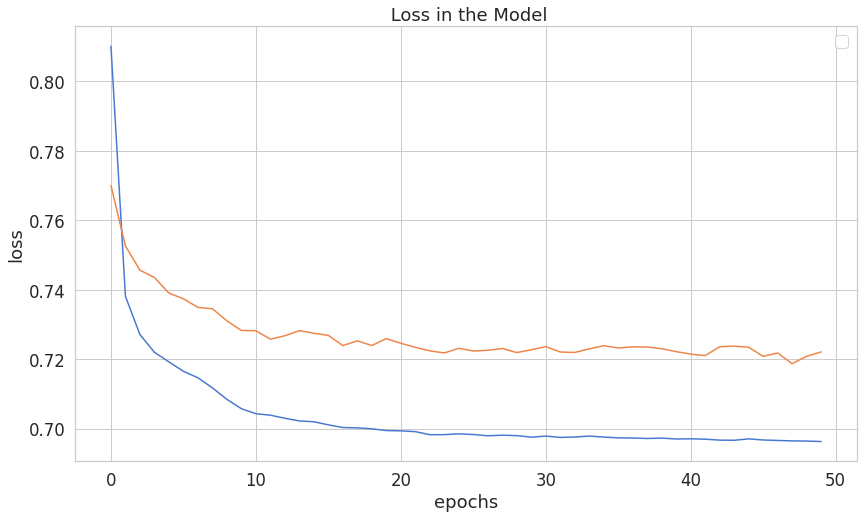

In [34]:
plt.title(' Loss in the Model')
plt.legend(['training Data', 'testing Data'], loc='upper right');
plt.ylabel('loss')
plt.xlabel('epochs')
plt.plot(history['loss'])
plt.plot(history['val_loss'])



In [35]:
predictions = autoencoder.predict(X_test)

2671/2671 [==============================] - 3s 1ms/step


In [36]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
errorDf = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [37]:
#Check for Reconstruction Errors
#As we demonstrate below, autoencoders are trained to minimize reconstruction error.
errorDf.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.717792,0.001592
std,3.329529,0.039865
min,0.032391,0.000000
25%,0.235207,0.000000
50%,0.380212,0.000000
75%,0.611760,0.000000
max,263.686291,1.000000


**ROC**

Most binary classifiers are intended to produce receiver operating characteristic curves as their output. They are somewhat less useful because the data set we have is unbalanced. Why? Because there are so relatively few examples of fraud, you may create a really good-looking curve by assuming everything is normal.

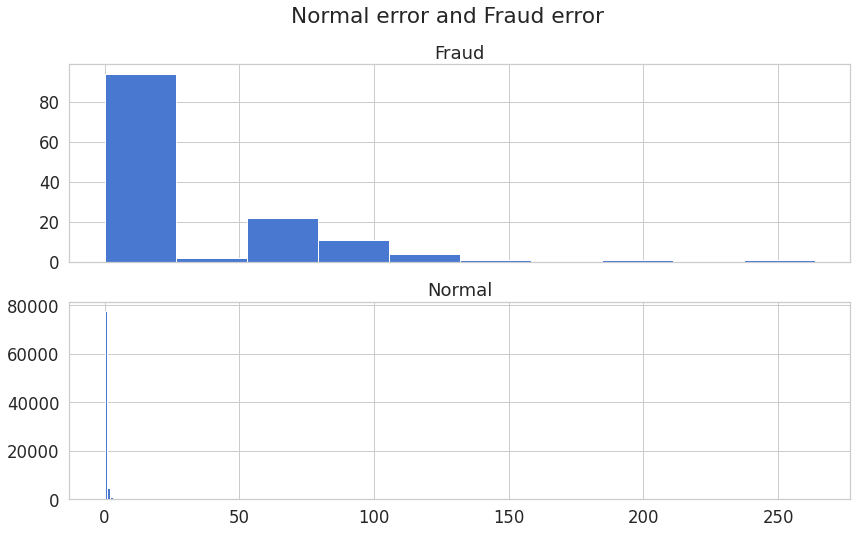

In [38]:
normalErrorDf = errorDf[(errorDf['true_class']== 0) & (errorDf['reconstruction_error'] < 10)]
fraudErrorDf = errorDf[errorDf['true_class'] == 1]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.suptitle('Normal error and Fraud error')

bins = 10

ax2.hist(normalErrorDf.reconstruction_error.values, bins = bins)
ax2.set_title('Normal')

ax1.hist(fraudErrorDf.reconstruction_error.values, bins = bins)
ax1.set_title('Fraud')

plt.show();

In [39]:
fpr, tpr, thresholds = roc_curve(errorDf.true_class, errorDf.reconstruction_error)
roc_auc = auc(fpr, tpr)

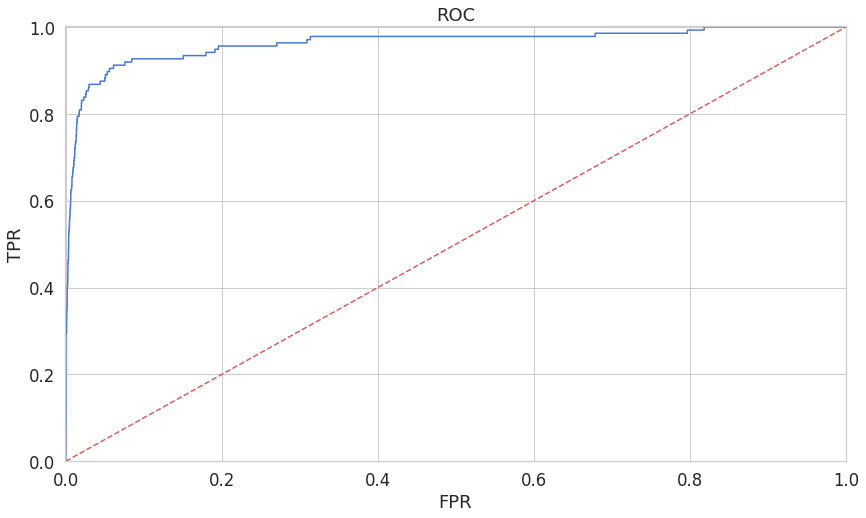

In [40]:
plt.title('ROC')
plt.ylim([0, 1.001])
plt.xlim([-0.001, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.show();

#### Precision Thresholding vs. Recall
Let's now examine the trade-off between recall and precision.

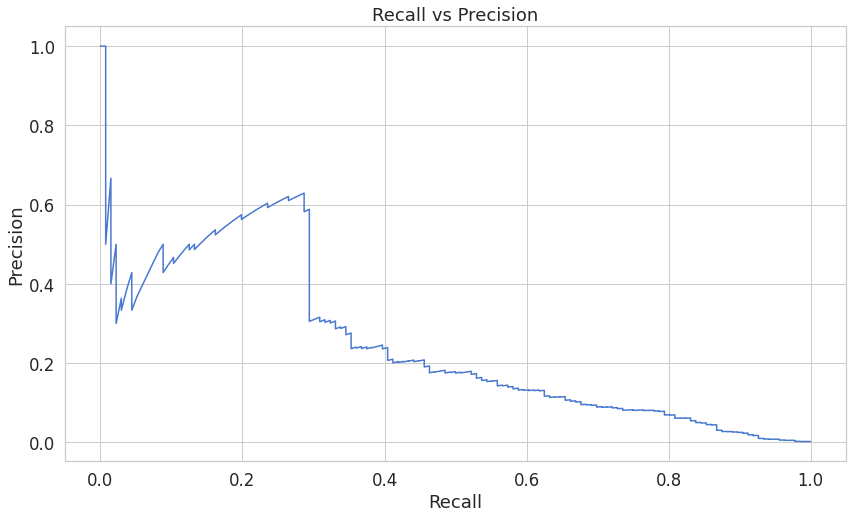

In [41]:
precision, recall, th = precision_recall_curve(errorDf.true_class, errorDf.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In data science, precision and recall are a constant tradeoff, therefore you eventually have to define an arbitrary boundary or threshold. It is simply a business decision where this boundary will be drawn. In this situation, you are weighing the costs of either missing a fraudulent transaction or incorrectly labeling a legitimate transaction as fraudulent.

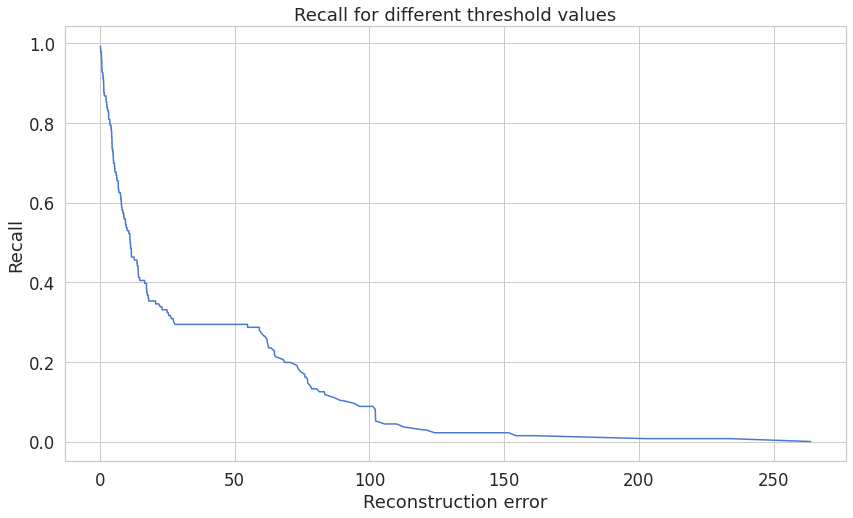

In [42]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.xlabel('Reconstruction error')
plt.title('Recall for different threshold values')
plt.ylabel('Recall')
plt.show()

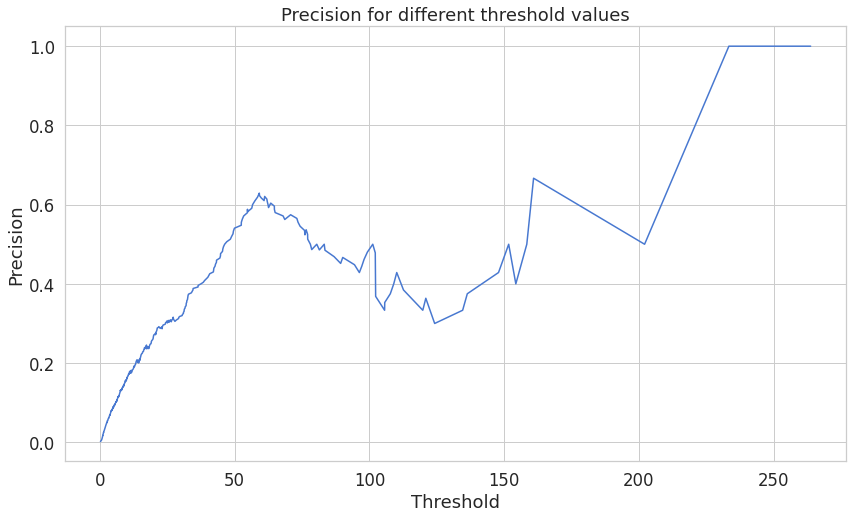

In [43]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision for different threshold values')
plt.show()


In [44]:
threshold = 2.9

**Threshold Check vs. Reconstruction**

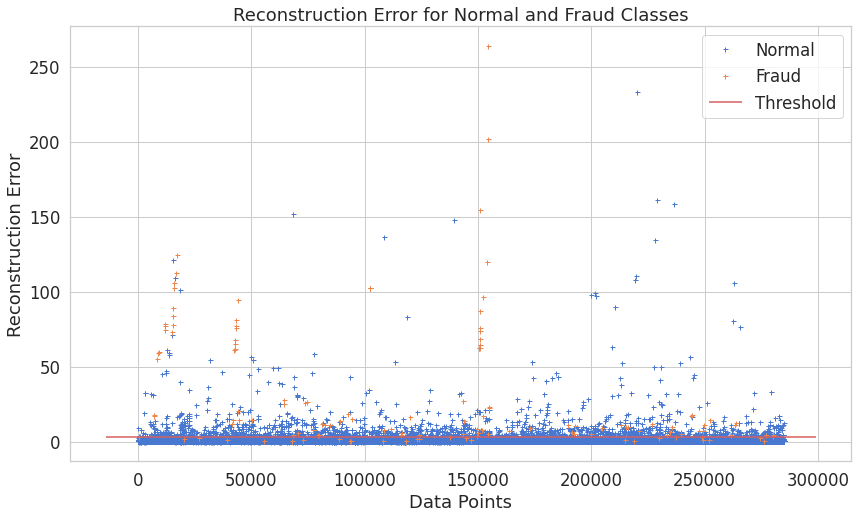

In [45]:
groups = errorDf.groupby('true_class')
f, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for Normal and Fraud Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Points")
plt.show();


We then examine a conventional confusion matrix for the 20% of the data that we had purposefully withheld from the testing set. Here, I particularly focus on the proportion of fraud cases that have been identified to false positives. If there are no business regulations or cost considerations that dominate that decision, a 1:10 ratio is a reasonably common benchmark.

In [46]:
#Confusion Matrix
y_pred = [1 if e > threshold else 0 for e in errorDf.reconstruction_error.values]
conf_matrix = confusion_matrix(errorDf.true_class, y_pred)

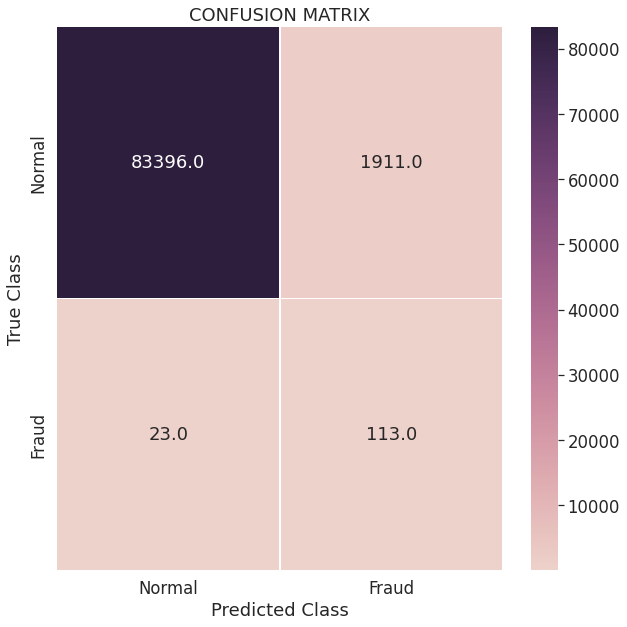

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, 
            xticklabels=LABELS, 
            yticklabels=LABELS, 
            annot=True, 
            fmt=".1f",
            linewidth=.5, 
            cmap=sns.cubehelix_palette(as_cmap=True));
plt.title("CONFUSION MATRIX")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()